In [175]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

In [176]:
class MLState(TypedDict):
    csv_path: str
    target: Optional[str]
    df: Optional[pd.DataFrame]
    problem_type: Optional[str]
    cleaned: Optional[bool]
    x: Optional[pd.DataFrame]
    y: Optional[pd.Series]
    X_train: Optional[pd.DataFrame]
    X_test: Optional[pd.DataFrame]
    y_train: Optional[pd.Series]
    y_test: Optional[pd.Series]
    y_pred:Optional[pd.Series]
    preprocess:Optional[dict]
    model: Optional[object]
    metrics: Optional[dict]
    visualization_done: Optional[bool]
    summary:str


In [177]:
def loader_agent(state:MLState):
    path=state.get("csv_path")
    dff = pd.read_csv(path)
    dataframe = pd.DataFrame(dff)
  
    return {"df":dataframe}

In [178]:
def problem_detector_agent(state:MLState):

    df=state["df"]
    target=state["target"]
    
    y=df[target]
    if pd.api.types.is_numeric_dtype(y):
        if y.nunique()<=20 and y.nunique()<len(y)*0.05:
            problem_type="classification"
        else:
            problem_type="regression"
    
    return {"target":target,"problem_type":problem_type}
    
        


In [179]:
def check_condition(state:MLState)->Literal["regression_cleaning_agent","classification_cleaning_agent"]:
    if state["problem_type"]=="classification":
        return "classification_cleaning_agent"
    else:
        return "regression_cleaning_agent"
 

In [180]:
def regression_cleaning_agent(state:MLState):
    df=state["df"]
    target=state["target"]
    
    #Normalize column name
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    #Drop fully null columns
    df = df.dropna(axis=1, how="all")
    
    #Drop rows with target is equal to null
    df = df[df[target].notna()].reset_index(drop=True)
    
    #Drop duplicates
    df=df.drop_duplicates(keep="first").reset_index(drop=True)
    
    #Drop Constant Columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    df = df.drop(columns=constant_cols)
    
    #Drop when null is greater than 0.8
    df = df.loc[:, df.isnull().mean() < 0.8]
    
    #outliers
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns

    for col in num_cols:
        skew = df[col].skew()

        if abs(skew) < 1:
            # Light skew → 5%–95% clipping
            low_q, high_q = 0.05, 0.95
        else:
            # Heavy skew → 1%–99% clipping
            low_q, high_q = 0.01, 0.99

        # compute limits
        lower = df[col].quantile(low_q)
        upper = df[col].quantile(high_q)

        # clip the values
        df[col] = df[col].clip(lower, upper)
    
    return {"df":df,"cleaned":True}

In [181]:
def classification_cleaning_agent(state:MLState):
    df=state["df"]
    target=state["target"]
    
    #Normalize column name
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    #Drop fully null columns
    df = df.dropna(axis=1, how="all")
    
    #Drop rows with target is equal to null
    df = df[df[target].notna()].reset_index(drop=True)
    
    #Drop duplicates
    df=df.drop_duplicates(keep="first").reset_index(drop=True)
    
    #Drop Constant Columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    df = df.drop(columns=constant_cols)
    
    #Drop when null is greater than 0.8
    df = df.loc[:, df.isnull().mean() < 0.8]
    
    #outliers
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns

    for col in num_cols:
        skew = df[col].skew()

        if abs(skew) < 1:
            # Light skew → 5%–95% clipping
            low_q, high_q = 0.05, 0.95
        else:
            # Heavy skew → 1%–99% clipping
            low_q, high_q = 0.01, 0.99

        # compute limits
        lower = df[col].quantile(low_q)
        upper = df[col].quantile(high_q)

        # clip the values
        df[col] = df[col].clip(lower, upper)
    
    return {"df":df,"cleaned":True}

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

def regression_eda_visualization_agent(state: MLState):
    df = state["df"]
    
    # Numerical features
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    
    # Plot histograms for numerical columns
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()
    
    # Plot bar plots for categorical columns
    for col in cat_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df)
        plt.title(f"Counts of {col}")
        plt.xticks(rotation=45)
        plt.show()
    
    
    return state


In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

def classification_eda_visualization_agent(state: MLState):
    df = state["df"]
    
    # Numerical features
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    
    # Plot histograms for numerical columns
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()
    
    # Plot bar plots for categorical columns
    for col in cat_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df)
        plt.title(f"Counts of {col}")
        plt.xticks(rotation=45)
        plt.show()
    
    
    return state

In [184]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

def regression_feature_engineering_agent(state:MLState):
    df = state["df"]
    target = state["target"]
    
    x= df.drop(columns=[target])
    y = df[target]
    
    num_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = x.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ])
    return {
        "preprocess": preprocessor,
        "x": x,
        "y": y
    }
    

In [185]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

def classification_feature_engineering_agent(state:MLState):
    df = state["df"]
    target = state["target"]
    
    x= df.drop(columns=[target])
    y = df[target]
    
    num_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = x.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ])
    return {
        "preprocess": preprocessor,
        "x": x,
        "y": y
    }

In [186]:
from sklearn.model_selection import train_test_split

def regression_train_test_split_agent(state: MLState):
    x, y = state["x"], state["y"]

    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }


In [187]:
from sklearn.model_selection import train_test_split

def classification_train_test_split_agent(state: MLState):
    x, y = state["x"], state["y"]

    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

In [188]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline

def regression_modeling_agent(state: MLState):
    preprocessor = state["preprocess"]
    
    model=LinearRegression()

    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipeline.fit(state["X_train"], state["y_train"])

    return {
        "model": pipeline
    }


In [189]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline

def classification__modeling_agent(state: MLState):
    preprocessor = state["preprocess"]
    
    model=LogisticRegression()

    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipeline.fit(state["X_train"], state["y_train"])

    return {
        "model": pipeline
    }

In [190]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score,mean_absolute_error

def regression_evaluation_agent(state: MLState):
    model = state.get("model")
    X_test = state.get("X_test")
    y_test = state.get("y_test")

    y_pred= model.predict(X_test)
    y_pred_series=pd.Series(y_pred, index=y_test.index)
    metrics = {
            "mse": mean_squared_error(y_test,y_pred),
            "r2": r2_score(y_test,y_pred),
            "mae":mean_absolute_error(y_test,y_pred)
        }

    return {
        "metrics": metrics,
        "y_pred":y_pred_series
    }


In [191]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

def classification_evaluation_agent(state: MLState):
    model = state.get("model")
    X_test = state.get("X_test")
    y_test = state.get("y_test")

    y_pred= model.predict(X_test)
    y_pred_series=pd.Series(y_pred, index=y_test.index)
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    metrics = {
        "accuracy_score":accuracy_score(y_test,y_pred),
        "precision_score":precision,
        "recall_score":recall,
        "f1_score":f1 
        }

    return {
        "metrics": metrics,
        "y_pred":y_pred_series
    }

In [192]:
def regression_model_visualization_agent(state):
    y_true = state["y_test"]
    y_pred = state["y_pred"]
    
    print(f"y_true shape: {len(y_true)}, y_pred shape: {len(y_pred)}")  # DEBUG
    
    # Align if necessary
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length!")
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Regression: Actual vs Predicted")
    plt.show()
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    state["metrics"] = {"mse": mse, "r2": r2}
    print(f"MSE: {mse:.4f}, R2: {r2:.4f}")
    
    return state

    


In [193]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
def classification_model_visualization_agent(state: MLState):
    
    y_true = state.get("y_test")
    y_pred = state.get("y_pred")  
    
    y_true = state["y_test"]
    y_pred = state["y_pred"]
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    
    return state

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from dotenv import load_dotenv
import os

load_dotenv()

def summary(state:MLState):
    """
    Generates a textual summary/report of the dataset and target using an LLM.
    """
    df=state["df"]
    shape=df.shape
    target=state["target"]
    problem_type=state["problem_type"]
    results=state["metrics"]

    template = PromptTemplate(
        template="""You are an expert data scientist.Dataset shape: {shape},Target column: {target},problem_type:{problem_type},Model results: {results}  
        Write a concise report explaining:
        - Dataset characteristics
        - Target type and prediction problem
        - Model performance metrics
        - Recommendations for improvement
""",
        input_variables=["df.shape", "target", "results","problem_type"]
    )
    
    llm1=HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.7,task="text_generation",model_kwargs={"api_key":os.getenv("HUGGINGFACEHUB_API_TOKEN")})
    model=ChatHuggingFace(llm=llm1)
    
    parser=StrOutputParser()
    
    chain=template|model|parser
    
    output=chain.invoke({"shape":shape,"target":target,"results":results,"problem_type":problem_type})
    
    return {"summary":output}
    


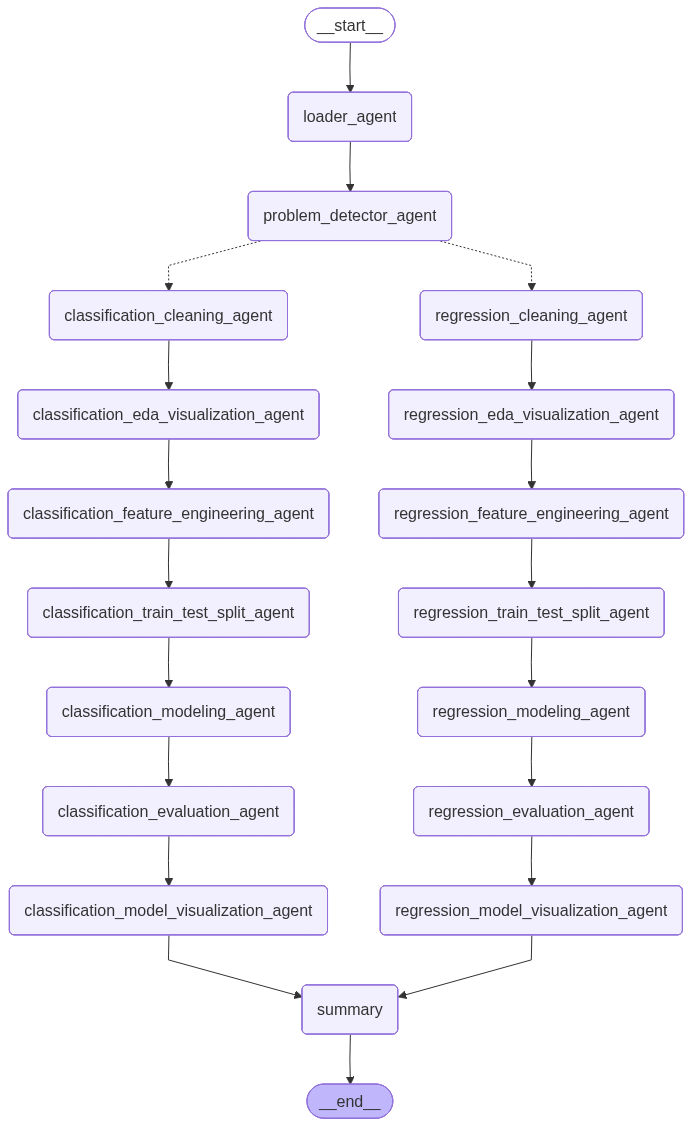

In [195]:
graph = StateGraph(MLState)

# Add nodes
graph.add_node("loader_agent",loader_agent)
graph.add_node("problem_detector_agent",problem_detector_agent)
graph.add_node("regression_cleaning_agent",regression_cleaning_agent)
graph.add_node("regression_eda_visualization_agent",regression_eda_visualization_agent)
graph.add_node("regression_feature_engineering_agent",regression_feature_engineering_agent)
graph.add_node("regression_train_test_split_agent",regression_train_test_split_agent)
graph.add_node("regression_modeling_agent",regression_modeling_agent)
graph.add_node("regression_evaluation_agent",regression_evaluation_agent)
graph.add_node("regression_model_visualization_agent",regression_model_visualization_agent)
graph.add_node("summary",summary)

graph.add_node("classification_cleaning_agent",classification_cleaning_agent)
graph.add_node("classification_eda_visualization_agent",classification_eda_visualization_agent)
graph.add_node("classification_feature_engineering_agent",classification_feature_engineering_agent)
graph.add_node("classification_train_test_split_agent",classification_train_test_split_agent)
graph.add_node("classification_modeling_agent",classification__modeling_agent)
graph.add_node("classification_evaluation_agent",classification_evaluation_agent)
graph.add_node("classification_model_visualization_agent",classification_model_visualization_agent)


graph.add_edge(START,"loader_agent")
graph.add_edge("loader_agent","problem_detector_agent")
graph.add_conditional_edges("problem_detector_agent",check_condition)
graph.add_edge("regression_cleaning_agent","regression_eda_visualization_agent")
graph.add_edge("regression_eda_visualization_agent","regression_feature_engineering_agent")
graph.add_edge("regression_feature_engineering_agent","regression_train_test_split_agent")
graph.add_edge("regression_train_test_split_agent","regression_modeling_agent")
graph.add_edge("regression_modeling_agent","regression_evaluation_agent")
graph.add_edge("regression_evaluation_agent","regression_model_visualization_agent")
graph.add_edge("regression_model_visualization_agent","summary")
graph.add_edge("summary",END)

graph.add_edge("classification_cleaning_agent","classification_eda_visualization_agent")
graph.add_edge("classification_eda_visualization_agent","classification_feature_engineering_agent")
graph.add_edge("classification_feature_engineering_agent","classification_train_test_split_agent")
graph.add_edge("classification_train_test_split_agent","classification_modeling_agent")
graph.add_edge("classification_modeling_agent","classification_evaluation_agent")
graph.add_edge("classification_evaluation_agent","classification_model_visualization_agent")
graph.add_edge("classification_model_visualization_agent","summary")
graph.add_edge('summary',END)


# Compile workflow
workflow = graph.compile()
workflow


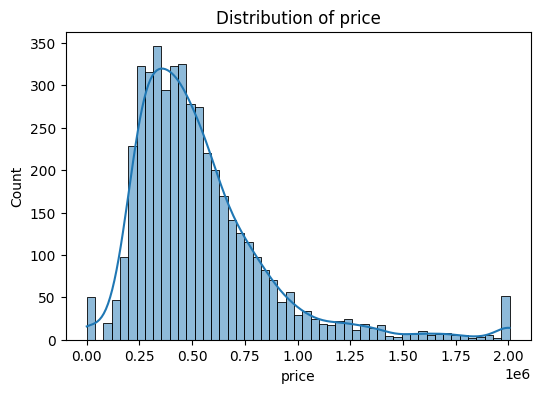

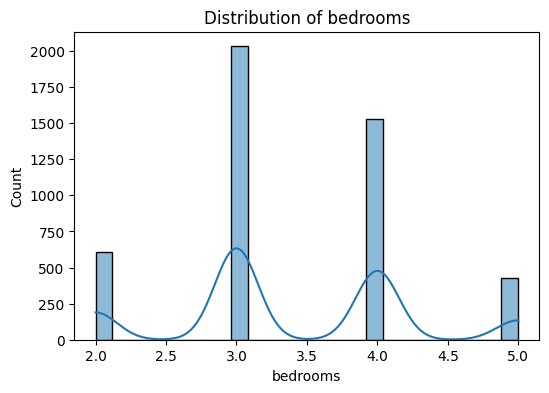

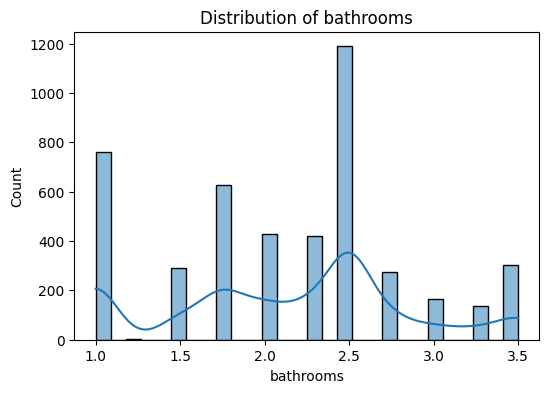

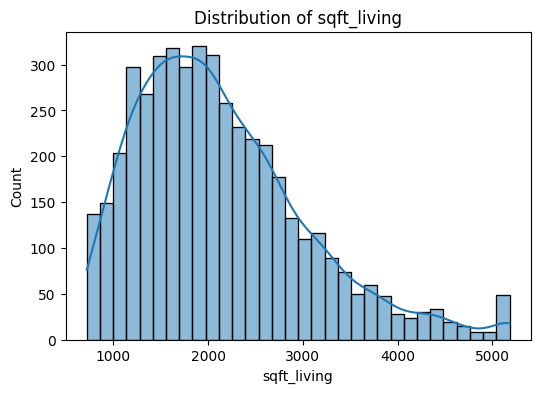

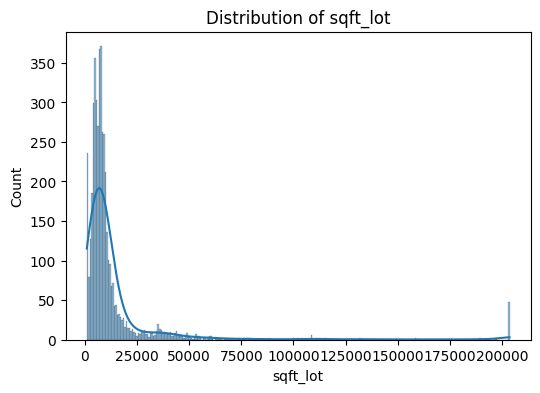

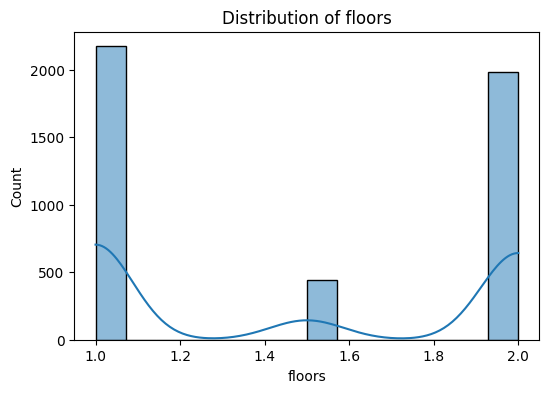

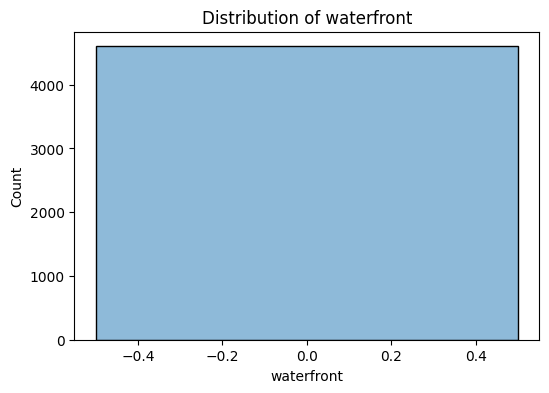

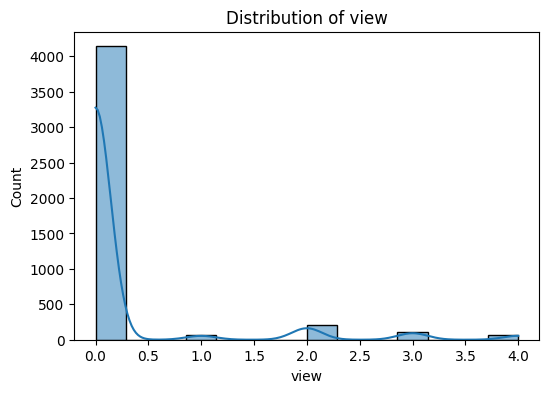

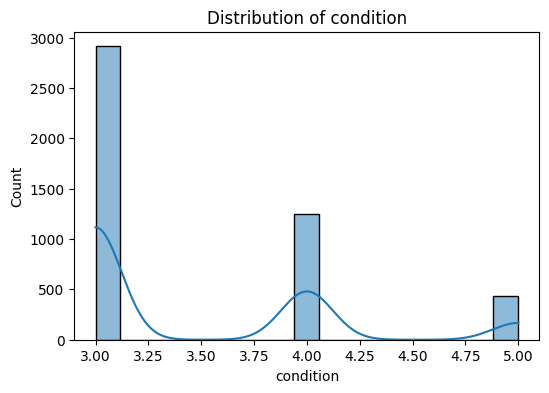

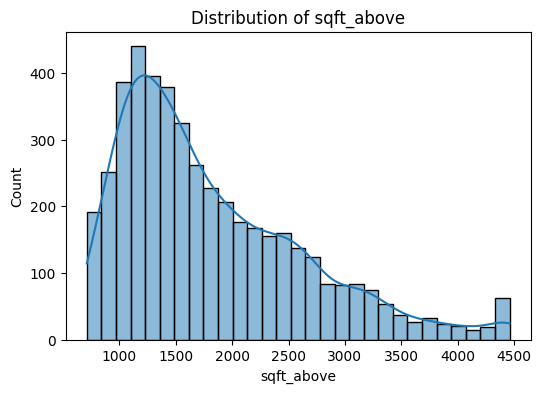

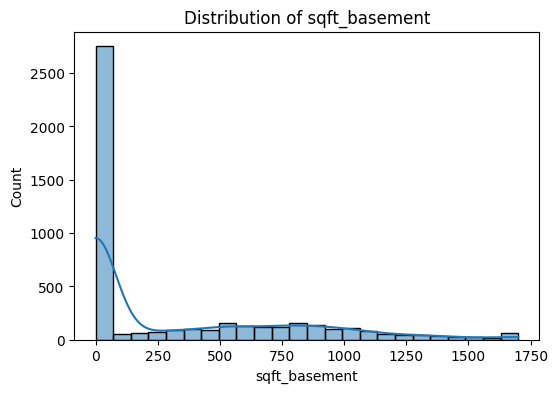

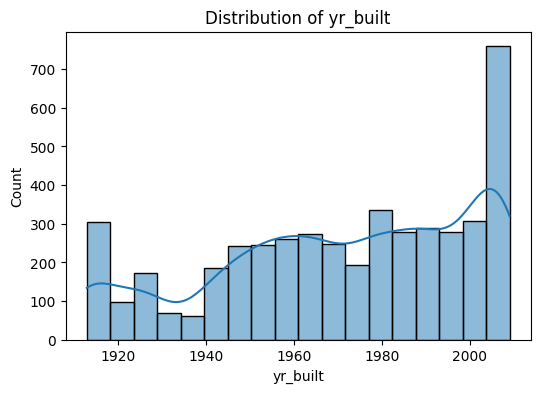

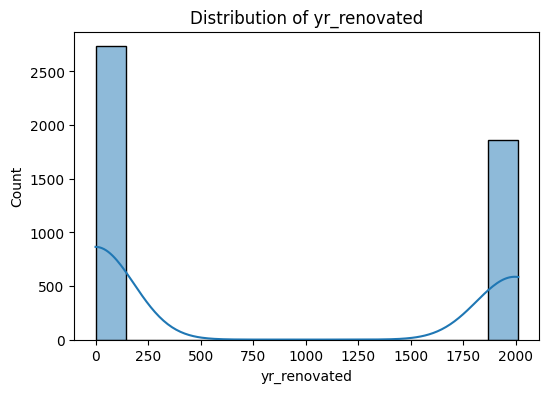

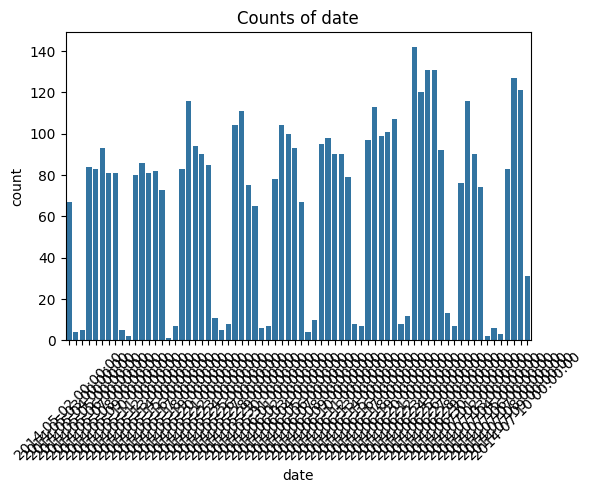

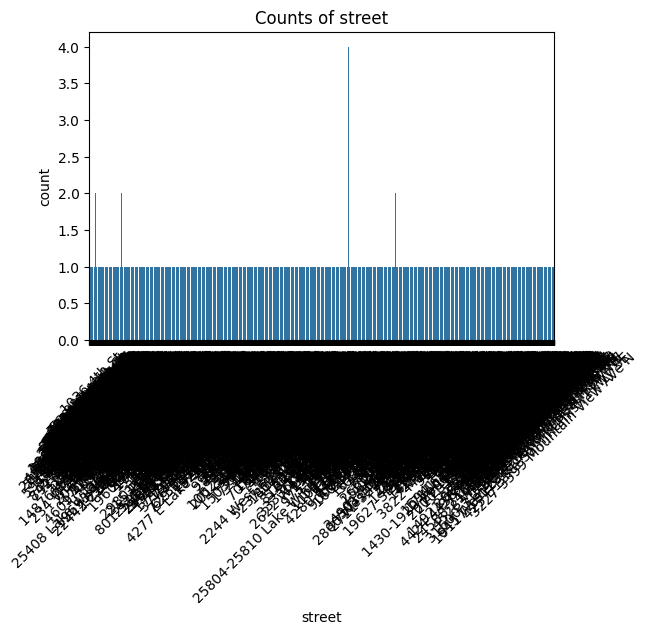

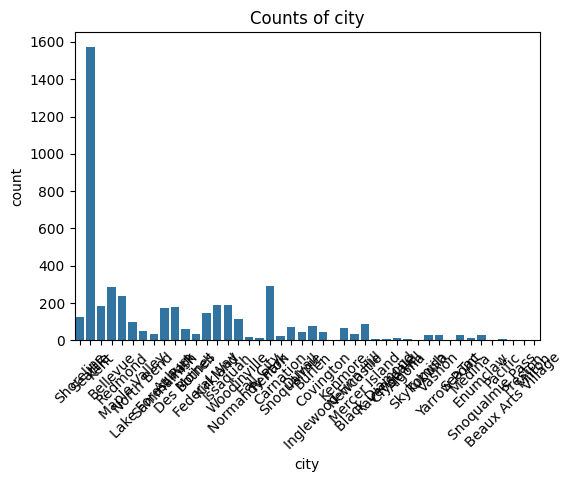

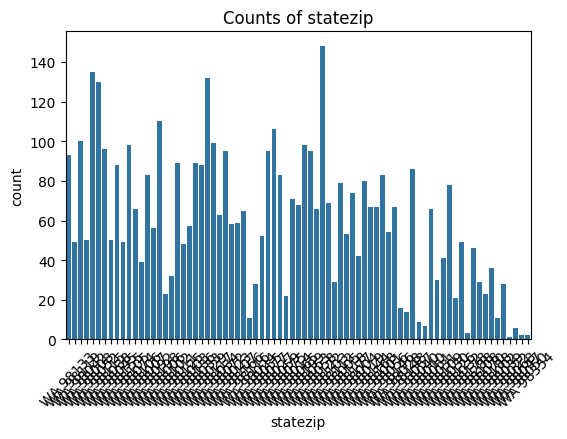

y_true shape: 920, y_pred shape: 920


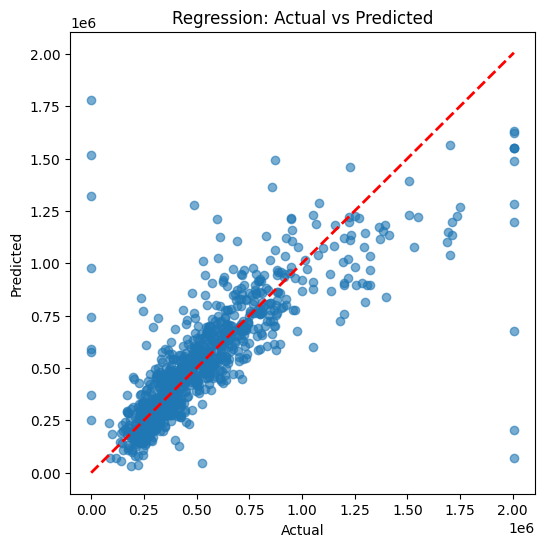

MSE: 42539559312.8860, R2: 0.6054


{'csv_path': 'D:\\Desktop\\Multiagent-Auto-ML-System\\Experiments\\data.csv',
 'target': 'price',
 'df':                      date         price  bedrooms  bathrooms  sqft_living  \
 0     2014-05-02 00:00:00  3.130000e+05       3.0       1.50       1340.0   
 1     2014-05-02 00:00:00  2.005220e+06       5.0       2.50       3650.0   
 2     2014-05-02 00:00:00  3.420000e+05       3.0       2.00       1930.0   
 3     2014-05-02 00:00:00  4.200000e+05       3.0       2.25       2000.0   
 4     2014-05-02 00:00:00  5.500000e+05       4.0       2.50       1940.0   
 ...                   ...           ...       ...        ...          ...   
 4595  2014-07-09 00:00:00  3.081667e+05       3.0       1.75       1510.0   
 4596  2014-07-09 00:00:00  5.343333e+05       3.0       2.50       1460.0   
 4597  2014-07-09 00:00:00  4.169042e+05       3.0       2.50       3010.0   
 4598  2014-07-10 00:00:00  2.034000e+05       4.0       2.00       2090.0   
 4599  2014-07-10 00:00:00  2.206000e+

In [196]:
initial_state={"csv_path":"D:\\Desktop\\Multiagent-Auto-ML-System\\Experiments\\data.csv","target":"price"}
output=workflow.invoke(initial_state)
output


In [199]:
output["summary"]

'**Report – Iris‑like Dataset (149\u202fsamples, 5 columns)**  \n\n| Item | Details |\n|------|---------|\n| **Dataset shape** | 149 rows × 5 columns (4 features + 1 target) |\n| **Target column** | `species` (categorical, 3 classes) |\n| **Problem type** | Multi‑class classification |\n\n---\n\n### 1. Dataset characteristics  \n* **Feature distribution** – Continuous, measured in the same units as the classic Iris data (e.g., sepal length/width, petal length/width).  \n* **Class balance** – Approximately equal representation (≈\u202f50 samples per species).  \n* **Size** – Very small (149 samples); any model will quickly overfit if not regularised or cross‑validated.  \n* **Potential leakage** – All samples appear to be drawn from a single source; no obvious train/test split was applied.\n\n### 2. Target type & prediction problem  \n* The target `species` is nominal with three distinct labels.  \n* The goal is to assign each observation to the correct species based on the four continu

In [197]:
# from sklearn.datasets import load_iris
# import pandas as pd

# iris = load_iris()
# df = pd.DataFrame(iris.data, columns=iris.feature_names)
# df['species'] = iris.target  # Target column

# df.to_csv("iris.csv", index=False)


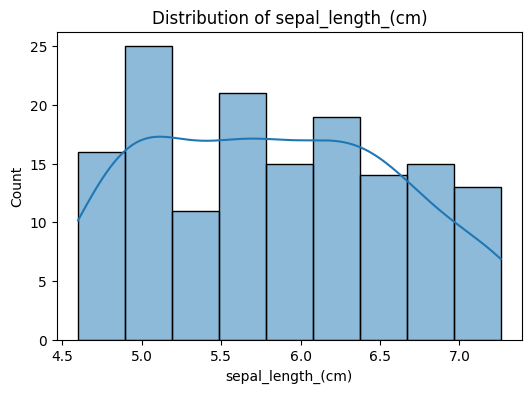

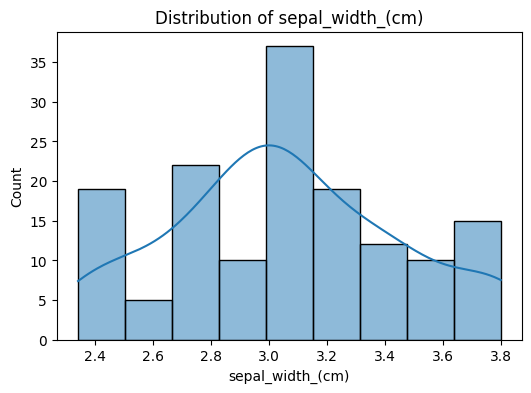

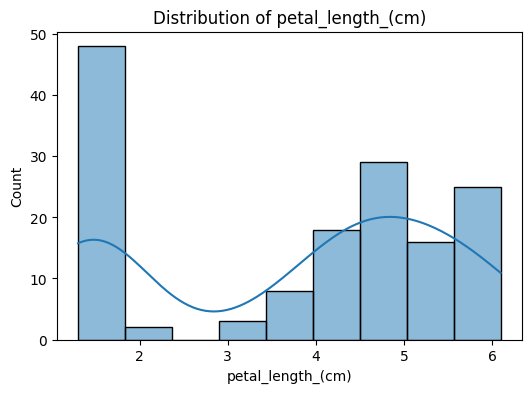

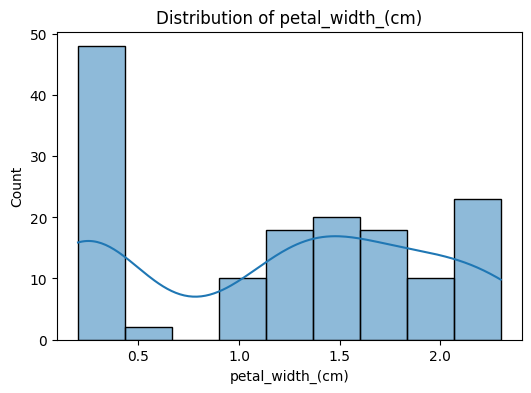

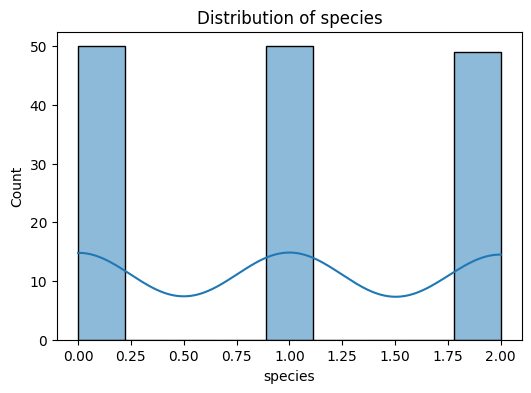

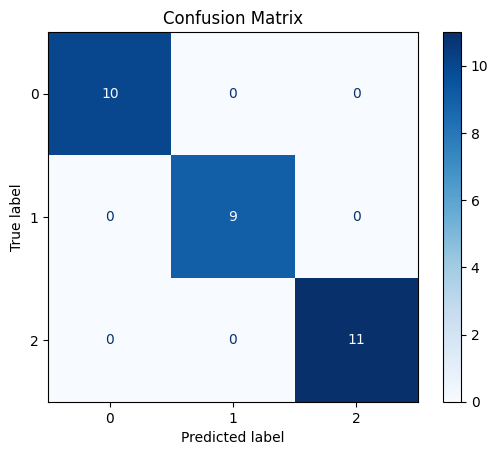

{'csv_path': 'D:\\Desktop\\Multiagent-Auto-ML-System\\Experiments\\iris.csv',
 'target': 'species',
 'df':      sepal_length_(cm)  sepal_width_(cm)  petal_length_(cm)  petal_width_(cm)  \
 0                  5.1               3.5                1.4               0.2   
 1                  4.9               3.0                1.4               0.2   
 2                  4.7               3.2                1.3               0.2   
 3                  4.6               3.1                1.5               0.2   
 4                  5.0               3.6                1.4               0.2   
 ..                 ...               ...                ...               ...   
 144                6.7               3.0                5.2               2.3   
 145                6.3               2.5                5.0               1.9   
 146                6.5               3.0                5.2               2.0   
 147                6.2               3.4                5.4              

In [198]:
initial_state={"csv_path":"D:\\Desktop\\Multiagent-Auto-ML-System\\Experiments\\iris.csv","target":"species"}
output=workflow.invoke(initial_state)
output

In [201]:
print(output["summary"])

**Report – Iris‑like Dataset (149 samples, 5 columns)**  

| Item | Details |
|------|---------|
| **Dataset shape** | 149 rows × 5 columns (4 features + 1 target) |
| **Target column** | `species` (categorical, 3 classes) |
| **Problem type** | Multi‑class classification |

---

### 1. Dataset characteristics  
* **Feature distribution** – Continuous, measured in the same units as the classic Iris data (e.g., sepal length/width, petal length/width).  
* **Class balance** – Approximately equal representation (≈ 50 samples per species).  
* **Size** – Very small (149 samples); any model will quickly overfit if not regularised or cross‑validated.  
* **Potential leakage** – All samples appear to be drawn from a single source; no obvious train/test split was applied.

### 2. Target type & prediction problem  
* The target `species` is nominal with three distinct labels.  
* The goal is to assign each observation to the correct species based on the four continuous attributes.

### 3. Model